In [1]:
import json
import numpy as np
from scipy import misc
from reader import Data
from matplotlib import pyplot as plt
import cv2
%matplotlib inline
from tensorpack import *

In [2]:
augmentors = [
    imgaug.RandomOrderAug(
        [imgaug.Brightness(30, clip=False),
         imgaug.Contrast((0.8, 1.2), clip=False),
         imgaug.Saturation(0.4),
         imgaug.Lighting(0.1,
                         eigval=[0.2175, 0.0188, 0.0045][::-1],
                         eigvec=np.array(
                             [[-0.5675, 0.7192, 0.4009],
                              [-0.5808, -0.0045, -0.8140],
                              [-0.5836, -0.6948, 0.4203]],
                             dtype='float32')[::-1, ::-1]
                         )]),
    imgaug.Clip(),
    imgaug.ToUint8()
]

In [3]:
batch_size = 1
period = 1
ds = Data("voc_2007_train.txt",
          shuffle=False,
          flip=False,
          affine_trans=True,
          use_multi_scale=True,
          period=batch_size * period)
ds = AugmentImageComponent(ds, augmentors)
ds = BatchData(ds, 1)

In [4]:
# test multi-scale training data
tx_ary = []
ty_ary = []
tw_ary = []
th_ary = []
tprob_ary = []
ds.reset_state()
for d in ds.get_data():
    data = d
    image = d[0][0]
    truth_boxes = d[7][0]
    klass = d[5][0]
    print(d[0][0].shape)
    break

AAAAAAAAAAAAAAAAAAAA
/home/jesse/tensorflow_workspace/tensorpack/examples/YOLOv2/VOCdevkit/VOC2007/JPEGImages/000012.jpg 156 97 351 270 6
/home/jesse/tensorflow_workspace/tensorpack/examples/YOLOv2/VOCdevkit/VOC2007/JPEGImages/000012.jpg
AAAAAAAAAAAAAAAAAAAA


AttributeError: 'NoneType' object has no attribute 'shape'

In [8]:
label_height = 14
label_width = len(klass) * 10
for box in truth_boxes:
    if box[2] == 0:
        continue
    box_p = box * 32
    xmin = int(box_p[1] - box_p[3] / 2)
    ymin = int(box_p[0] - box_p[2] / 2)
    xmax = int(box_p[1] + box_p[3] / 2)
    ymax = int(box_p[0] + box_p[2] / 2)
    cv2.rectangle(image,
                  (xmin, ymin),
                  (xmax, ymax),
                  (255, 0, 0),
                  3)

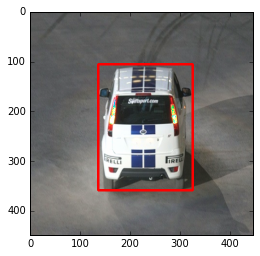

In [9]:
plt.imshow(image)

In [20]:
misc.imsave("output.jpg", image)

In [4]:
tx_ary = []
ty_ary = []
tw_ary = []
th_ary = []
tprob_ary = []
ds.reset_state()
for d in ds.get_data():
    print("sample ground truth value:")
    [img, tx, ty, tw, th, tprob, spec_mask, _] = d
    spec_mask = spec_mask.astype(float)
    truth_idx = np.argwhere(spec_mask.max() == spec_mask)
    print("spec_mask: " + str(truth_idx))
    tx_ary.append(tx)
    ty_ary.append(ty)
    tw_ary.append(tw)
    th_ary.append(th)
    tprob_ary.append(tprob)

sample ground truth value:
spec_mask: [[ 0  8  7]
 [ 0  8 10]
 [ 0  8 11]
 [ 0  9  2]
 [ 0  9  4]]
sample ground truth value:
spec_mask: [[ 0  5 10]
 [ 2  6  4]
 [ 2  6  8]]
sample ground truth value:
spec_mask: [[ 2  6 11]
 [ 4  6  4]]
sample ground truth value:
spec_mask: [[2 4 3]]
sample ground truth value:
spec_mask: [[2 6 6]
 [4 6 6]]
sample ground truth value:
spec_mask: [[4 6 5]]
sample ground truth value:
spec_mask: [[4 5 6]]
sample ground truth value:
spec_mask: [[0 1 1]
 [0 1 2]
 [0 1 3]
 [1 1 0]
 [4 7 6]]
sample ground truth value:
spec_mask: [[ 0  6  5]
 [ 0  7 11]
 [ 0  9 11]
 [ 1 10  7]
 [ 1 11  1]
 [ 1 12  5]
 [ 3 11  4]]
sample ground truth value:
spec_mask: [[ 0  8 11]
 [ 3  7  8]]
sample ground truth value:
spec_mask: [[ 2  6  1]
 [ 2  7  3]
 [ 2  7  5]
 [ 2  7  7]
 [ 2  7  8]
 [ 2  7 11]]
sample ground truth value:
spec_mask: [[3 6 8]]
sample ground truth value:
spec_mask: [[3 9 9]
 [4 7 5]]
sample ground truth value:
spec_mask: [[ 1  3 12]
 [ 2  4  6]
 [ 2  7  2]
 [

In [17]:
img.shape

(384, 1280, 3)

In [31]:
spec_mask.shape

(5, 12, 40)

In [32]:
tx.shape

(5, 1, 12, 40)

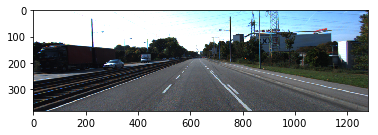

In [16]:
plt.imshow(img)

In [19]:
x = tx_ary[0][2, 0, 6, 9]
y = ty_ary[0][2, 0, 6, 9]
w = tw_ary[0][2, 0, 6, 9]
h = th_ary[0][2, 0, 6, 9]

In [20]:
anchors = [[1.06593733, 1.03880763], [2.08908397, 4.90636738], [2.35326204, 1.43357071], [4.52926972, 2.49737608], [8.66448722, 4.9158313]]
anchor = anchors[2]
center_w_cell = 9 + x
center_h_cell = 6 + y
box_w_cell = np.exp(w) * anchor[0]
box_h_cell = np.exp(h) * anchor[1]

In [21]:
center_w_pixel = center_w_cell * 32
center_h_pixel = center_h_cell * 32
box_w_pixel = box_w_cell * 32
box_h_pixel = box_h_cell * 32

In [22]:
top_left_x = (int)(center_w_pixel - box_w_pixel // 2)
top_left_y = (int)(center_h_pixel - box_h_pixel // 2)
bottom_right_x = (int)(center_w_pixel + box_w_pixel // 2)
bottom_right_y = (int)(center_h_pixel + box_h_pixel // 2)

In [23]:
image_result = np.copy(img)

In [28]:
image_result = cv2.rectangle(image_result,
              (top_left_x, top_left_y),
              (bottom_right_x, bottom_right_y),
              (255, 0, 0),
              3)

True

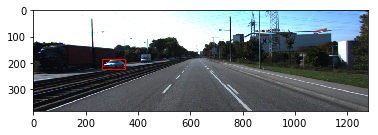

In [30]:
plt.imshow(image_result)
write_image = cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB)
cv2.imwrite("reader.png", write_image)

In [42]:
tx_ary[1][3, 0, 6, 5]

0.551

In [43]:
ty_ary[1][3, 0, 6, 5]

0.57807809

In [44]:
tw_ary[1][3, 0, 6, 5]

-0.46715778

In [45]:
th_ary[1][3, 0, 6, 5]

-0.30209705